# XBeach bathy demo

Usage demo for the XBeachBathy object

### Requirements

- Clone and install the [main](https://github.com/rom-py/rompy-xbeach) version of rompy-xbeach

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from rompy_xbeach.grid import GeoPoint, RegularGrid

import warnings
warnings.filterwarnings("ignore")

## Read bathy

Read bathy from the test data in the rompy-xbeach repo to inspect it and help it to define the model grid

In [3]:
bathy = rioxarray.open_rasterio("../../../rompy-xbeach/tests/data/bathy.tif")
bathy = bathy.isel(band=0, drop=True)
bathy

<xarray.DataArray (y: 180, x: 176)> Size: 127kB
[31680 values with dtype=float32]
Coordinates:
  * x            (x) float64 1kB 115.6 115.6 115.6 115.6 ... 115.6 115.6 115.6
  * y            (y) float64 1kB -32.65 -32.65 -32.65 ... -32.61 -32.61 -32.61
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

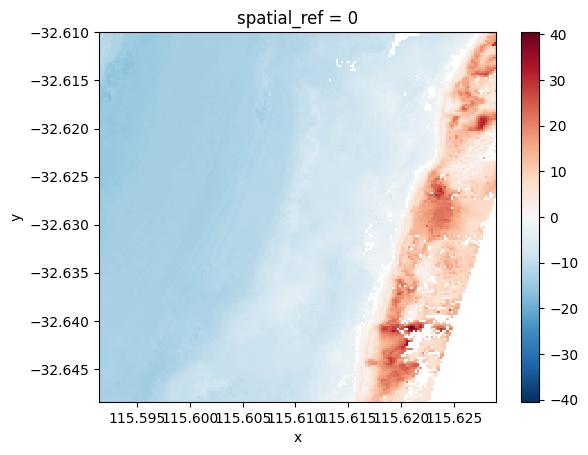

In [4]:
# The bathy is in lat/lon

bathy.plot()

## Set the grid

Define the XBeach grid object in `EPSG:28350` projection (use latlon to specify the origin)

In [5]:
from pyproj import CRS

In [6]:
grid = RegularGrid(
    ori=GeoPoint(
        x=115.594239,
        y=-32.641104,
        crs=bathy.rio.crs,
    ),
    alfa=347,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

### Plot grid on bathy

The origin and rotation of the grid need to be defined such that the offshore boundary
of the interpolated bathymetry data corresponds to the first row and column. The `grid.plot()`
method highlights the origin and offshore boundary in red to assist with the grid definition

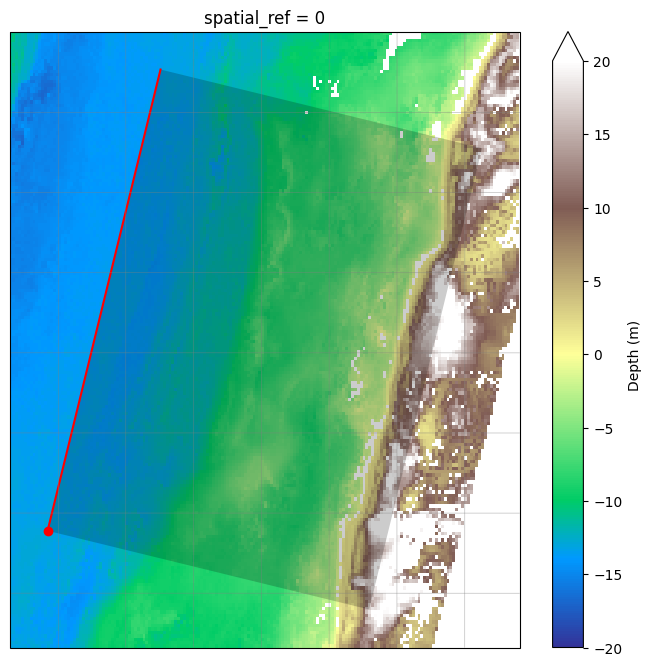

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": grid.projection}, figsize=(8.5, 8))

# Bathymetry
bathy.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Depth (m)"),
)

# Grid
ax = grid.plot(
    ax=ax,
    buffer=250,
    grid_kwargs=dict(facecolor="k", alpha=0.2),
    show_offshore=True,
    show_origin=True,
)

<div class="alert alert-block alert-warning">
⚠️ Here we will define another grid by poorly selecting the origin and rotation
</div>

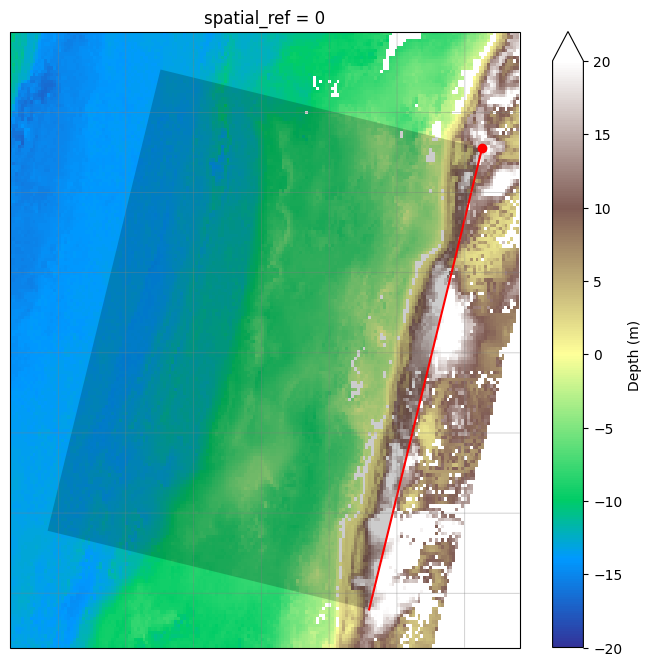

In [8]:
# Define origin at the NE corner of the existing grid
x0 = grid.x[-1, -1]
y0 = grid.y[-1, -1]

# Notice we are now specifying the origin in projected coordinates!
grid_bad = RegularGrid(
    ori=GeoPoint(x=x0, y=y0, crs=28350),
    alfa=347-180,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

# Plotting
fig, ax = plt.subplots(subplot_kw={"projection": grid.projection}, figsize=(8.5, 8))
bathy.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Depth (m)"),
)
ax = grid_bad.plot(ax=ax, buffer=250, grid_kwargs=dict(facecolor="k", alpha=0.2))

## Set Data object

In [9]:
from rompy_xbeach.source import SourceGeotiff
from rompy_xbeach.data import XBeachBathy, SeawardExtensionLinear
from rompy_xbeach.interpolate import RegularGridInterpolator

### Example 1: no extension of the grid

We start off by defining source and interpolator instances

In [10]:
# The source instance provides the source dataset with the CRS information
source = SourceGeotiff(filename="../../../rompy-xbeach/tests/data/bathy.tif")

# The interpolator instance specify how the interpolation will be done
interpolator = RegularGridInterpolator(
    kwargs=dict(
        method="linear",
        fill_value=None,
    ),
)

Then we instantiate the bathy data object

In [11]:
data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
)

Lastly, we use the previously defined grid instance to interpolate the bathy onto

In [12]:
workspace = Path("./examples")
workspace.mkdir(exist_ok=True)

xfile1, yfile1, datafile1, grid1 = data.get(destdir=workspace, grid=grid)
sorted(workspace.glob("*.txt"))

[PosixPath('examples/bathy.txt'),
 PosixPath('examples/xdata.txt'),
 PosixPath('examples/ydata.txt')]

The xbeach accessor can be used to read the output data into a xarray Dataset and plot the bathy

In [13]:
# Read the data
dset1 = xr.Dataset.xbeach.from_xbeach(datafile1, grid1)
dset1

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 220, x: 230)
Coordinates:
    xc           (y, x) float64 405kB 3.681e+05 3.682e+05 ... 3.711e+05
    yc           (y, x) float64 405kB 6.388e+06 6.388e+06 ... 6.39e+06 6.39e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables:
    dep          (y, x) float64 405kB -13.1 -13.08 -13.08 ... 14.63 14.45 14.53

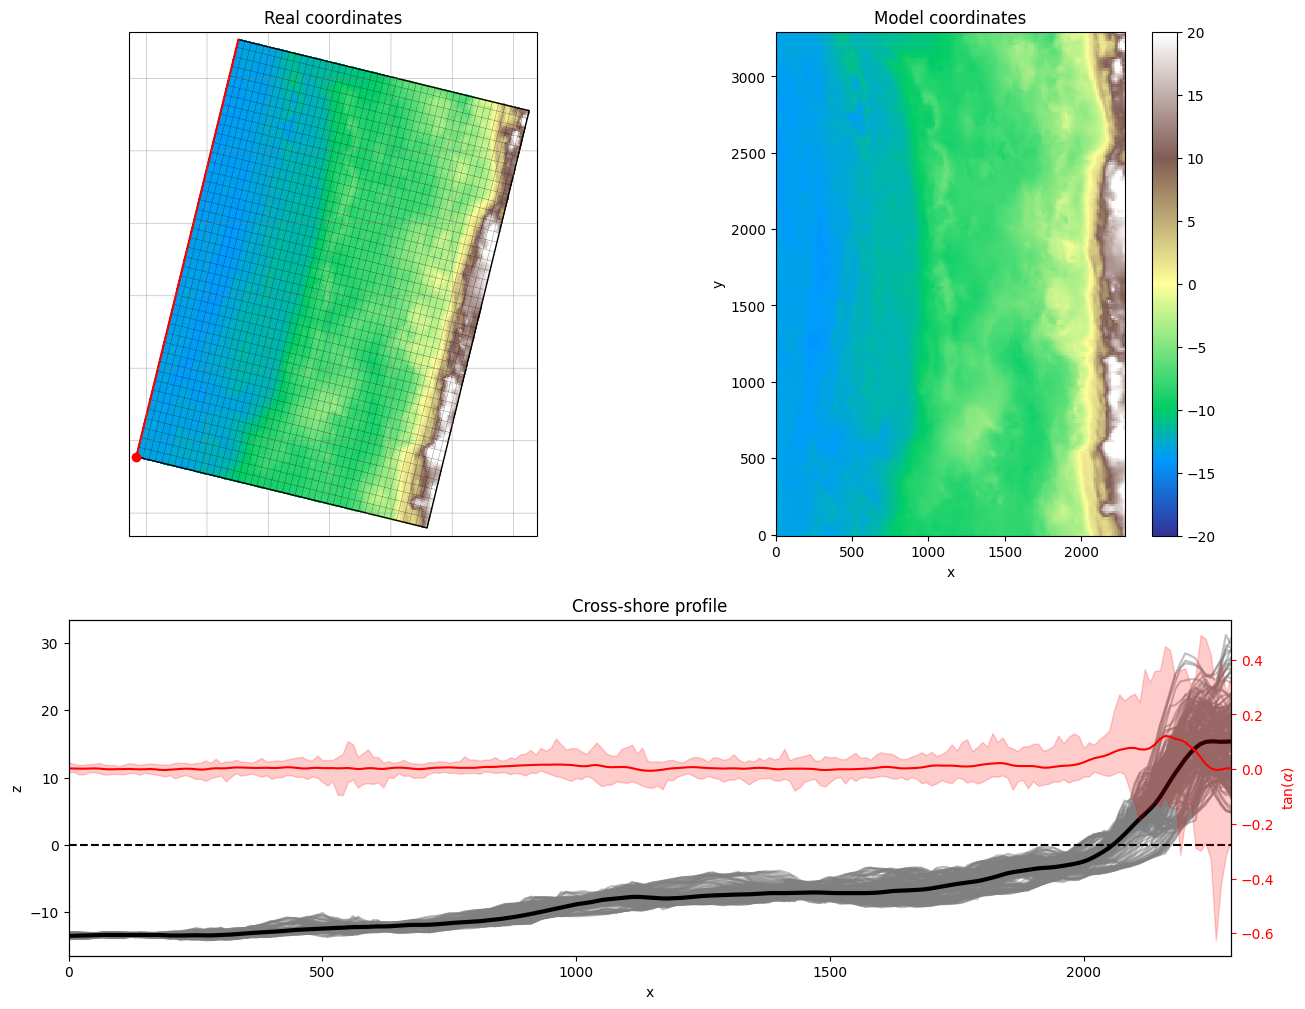

In [14]:
# Plot the data
dset1.xbeach.plot_model_bathy(grid1, posdwn=False)

### Example 2: Extend offshore boundary

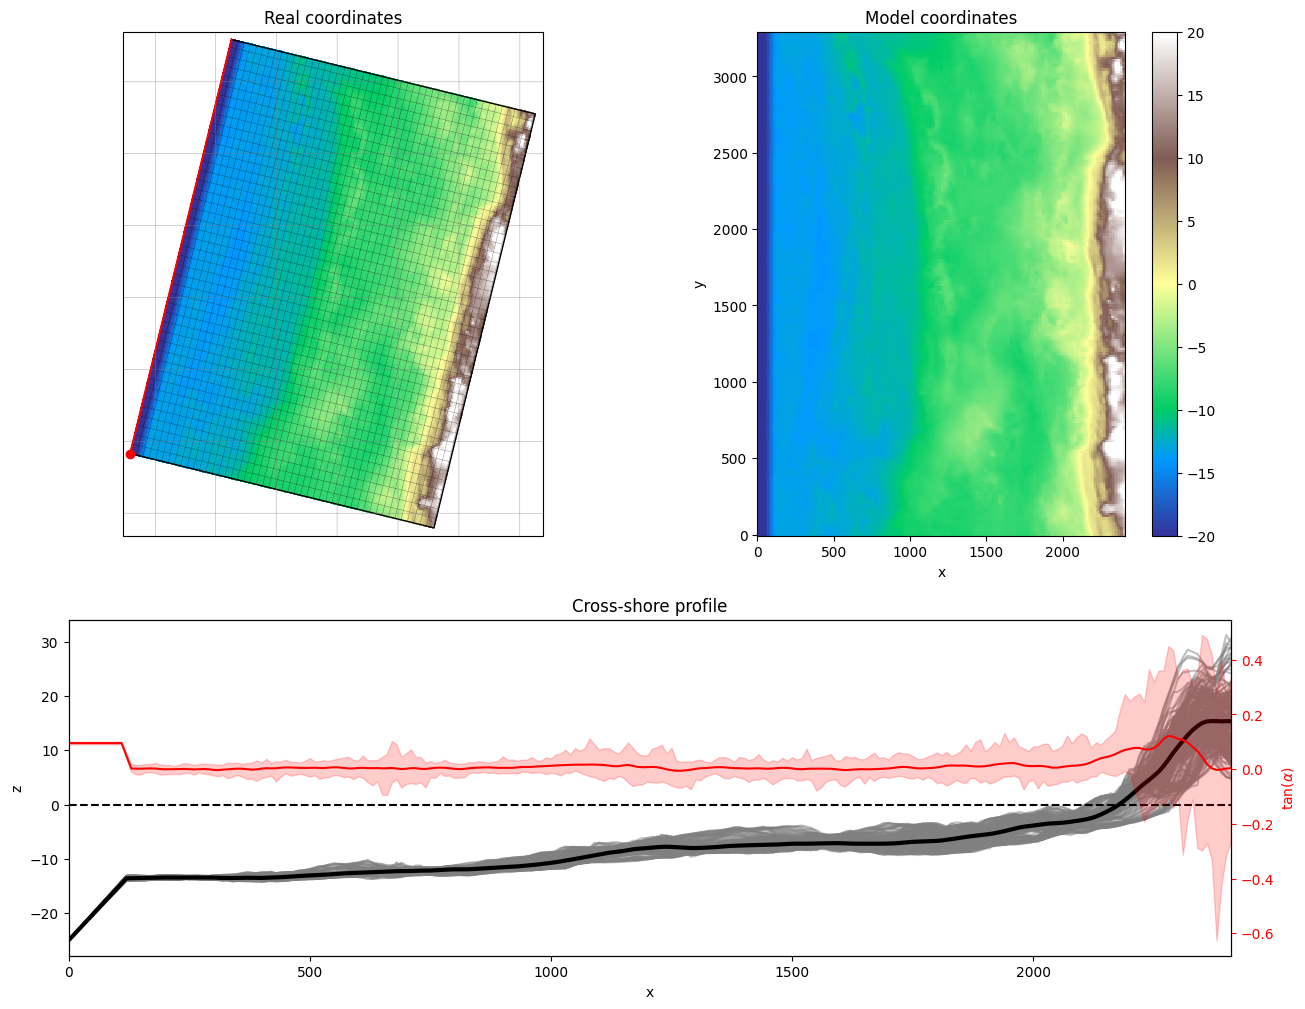

In [15]:
# The offshore extension is prescribed using one of the SeawardExtension subclasses
extension = SeawardExtensionLinear(
    depth=25,
    slope=0.1,
)

# Instantiate the data object with the new extension
data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
)

# Generate the grid data
xfile2, yfile2, datafile2, grid2 = data.get(destdir=workspace, grid=grid)

# Plot the new bathy
dset2 = xr.Dataset.xbeach.from_xbeach(datafile2, grid2)
dset2.xbeach.plot_model_bathy(grid2, posdwn=False)

In [16]:
# Compare the shapes of the original and extended grid

print(dset1.dep.shape, grid1.shape)
print(dset2.dep.shape, grid2.shape)

(220, 230) (220, 230)
(220, 242) (220, 242)


#### The lesser the slope the longer the extension

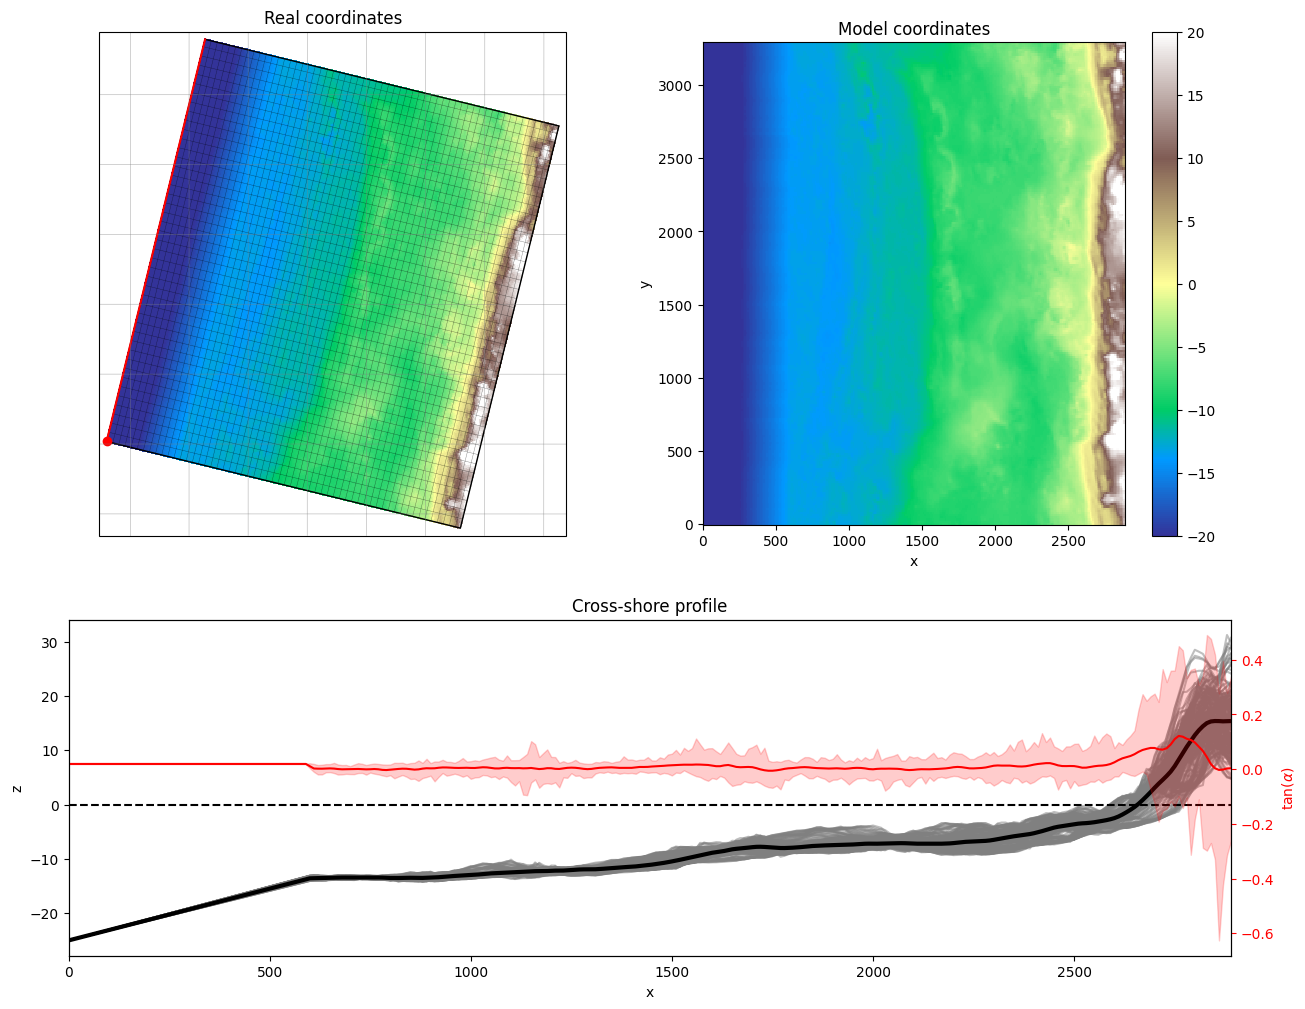

In [17]:
extension = SeawardExtensionLinear(
    depth=25,
    slope=0.02,
)

data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
)

xfile3, yfile3, datafile3, grid3 = data.get(destdir=workspace, grid=grid)

dset3 = xr.Dataset.xbeach.from_xbeach(datafile3, grid3)
dset3.xbeach.plot_model_bathy(grid3, posdwn=False)

### Exemple 3: extend offshore and lateral boundary

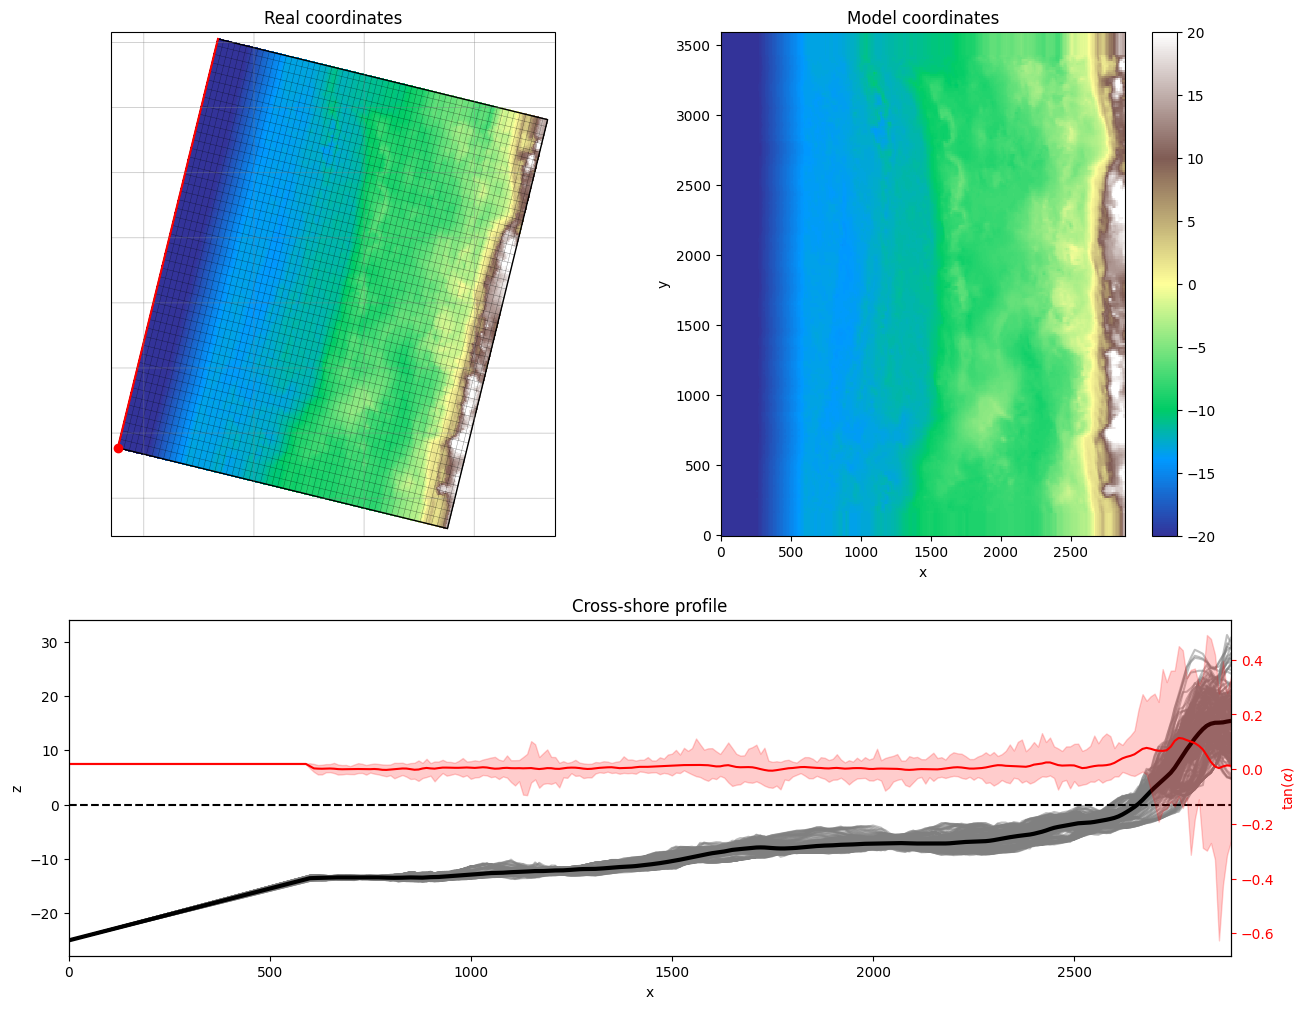

In [18]:
extension = SeawardExtensionLinear(
    depth=25,
    slope=0.02,
)

data = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
    left=10,
    right=10,
)

xfile4, yfile4, datafile4, grid4 = data.get(destdir=workspace, grid=grid)

dset4 = xr.Dataset.xbeach.from_xbeach(datafile4, grid4)
dset4.xbeach.plot_model_bathy(grid4, posdwn=False)

In [19]:
# Compare the shapes with and without the lateral extension

print(dset3.dep.shape, grid3.shape)
print(dset4.dep.shape, grid4.shape)

(220, 290) (220, 290)
(240, 290) (240, 290)
